<h1 align="center"> Analisis Dan Prediksi Data Time Series Cuaca </h1>

<div align="center">
  <img src="./alur kerja pertanian.png" alt="Diagram Alur Kerja Proyek" width="800"/>
</div>

<p align="justify">
Diagram alur kerja proyek yang menampilkan urutan tahapan inti—<strong>Problem Scoping → Data Wrangling → Eksplorasi Data → Modelling → Evaluasi → Deployment</strong>.  
Visual ini berfungsi sebagai peta jalan (road-map) agar selalu memahami konteks tahapan yang sedang ataupun akan dijalankan, membantu menjaga alur kerja tetap sistematis, terukur, dan tidak ada fase penting yang terlewat sebelum model dipublikasikan (deployment).
</p>



## 1. Problem Scoping
Dalam proyek ini, kita akan menganalisis data time series cuaca untuk memprediksi Suhu rata-rata (`TAVG`) berdasarkan berbagai parameter cuaca. Tujuan utama adalah membangun model machine learning seperti Random Forest yang dapat memperkirakan Suhu Rata Rata dengan akurat berdasarkan fitur-fitur seperti kelembapan, curah hujan, dan sinar matahari.


## 2. Data Wrangling
Data Wrangling (atau Data Munging) adalah proses transformasi dan pembersihan data mentah ke dalam format yang lebih sesuai untuk analisis. Pada proyek ini, tahapan Data Wrangling yang dilakukan meliputi:

### I. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from datetime import timedelta
import joblib

### II. Membaca dan Menilai Data Awal

In [2]:
df = pd.read_csv("../Dataset/dataset time series.csv")
print("Data awal:")
df.head()

Data awal:


,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,01-01-2020,24,29.6,26.3,88,23.5,3.4,6,280,2,C
1,02-01-2020,24.2,32.8,28.5,82,12.4,0.0,9,280,3,W
2,03-01-2020,25.8,32.0,28.2,82,0,8.3,12,300,5,NW
3,04-01-2020,26.2,31.6,28.3,82,0.4,5.8,8,300,5,W
4,05-01-2020,26.4,32.6,27.7,84,0.1,2.1,14,270,4,NW


### Keterangan:
- **Tn**: Temperatur minimum (°C)
- **Tx**: Temperatur maksimum (°C)
- **Tavg**: Temperatur rata-rata (°C)
- **RH_avg**: Kelembapan rata-rata (%)
- **RR**: Curah hujan (mm)
- **ss**: Lamanya penyinaran matahari (jam)
- **ff_x**: Kecepatan angin maksimum (m/s)
- **ddd_x**: Arah angin saat kecepatan maksimum (°)
- **ff_avg**: Kecepatan angin rata-rata (m/s)
- **ddd_car**: Arah angin terbanyak (°)


In [3]:
print("Informasi data:")
df.info()

Informasi data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TANGGAL  1887 non-null   object 
 1   TN       1887 non-null   object 
 2   TX       1887 non-null   float64
 3   TAVG     1887 non-null   float64
 4   RH_AVG   1887 non-null   int64  
 5   RR       1887 non-null   object 
 6   SS       1887 non-null   float64
 7   FF_X     1887 non-null   int64  
 8   DDD_X    1887 non-null   int64  
 9   FF_AVG   1887 non-null   int64  
 10  DDD_CAR  1887 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 162.3+ KB


In [4]:
print("Statistik deskriptif:")
df.describe()

Statistik deskriptif:


,TX,TAVG,RH_AVG,SS,FF_X,DDD_X,FF_AVG
count,1887.000000,1887.000000,1887.00000,1887.000000,1887.000000,1887.000000,1887.000000
mean,32.078908,28.469687,80.45257,6.660996,7.403286,185.336513,2.361420
std,1.269501,1.108534,6.80323,3.352550,2.437566,85.456051,1.222689
min,26.200000,24.300000,59.00000,0.000000,0.000000,0.000000,0.000000
25%,31.400000,27.700000,76.00000,4.000000,6.000000,120.000000,1.000000
50%,32.000000,28.400000,81.00000,7.900000,7.000000,150.000000,2.000000
75%,32.800000,29.200000,86.00000,9.700000,9.000000,280.000000,3.000000
max,35.800000,32.100000,98.00000,11.700000,19.000000,360.000000,7.000000


### III. Data Cleaning
Data Cleaning adalah proses mengidentifikasi dan memperbaiki masalah dalam dataset untuk memastikan kualitas data yang baik sebelum dilakukan analisis.

In [5]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(columns=["DDD_CAR", 'DDD_X'])

In [6]:
# Konversi semua kolom bertipe object ke numerik
for col in ["TN", "RR"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
# Mengubah kolom 'TANGGAL' ke format datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')

In [8]:
# Ganti nilai 8888 dan 9999 dengan None (NaN)
df = df.replace({8888: np.nan, 9999: np.nan})

In [9]:
# Memeriksa nilai yang hilang
print("Jumlah nilai yang hilang:")
df.isna().sum()

Jumlah nilai yang hilang:


TANGGAL      0
TN           1
TX           0
TAVG         0
RH_AVG       0
RR         127
SS           0
FF_X         0
FF_AVG       0
dtype: int64

In [10]:
# Menerapkan metode interpolasi untuk mengisi nilai yang hilang
df = df.interpolate(method='linear')

In [11]:
# Memeriksa nilai yang hilang
print("Jumlah nilai yang hilang setelah interpolasi:")
df.isna().sum()

Jumlah nilai yang hilang setelah interpolasi:


TANGGAL    0
TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
FF_AVG     0
dtype: int64

### IV. Feature Engineering (Rekayasa Fitur)
Feature Engineering adalah proses transformasi data mentah menjadi fitur-fitur yang lebih bermakna dan representatif untuk meningkatkan performa model machine learning. Pada analisis time series cuaca ini, dilakukan beberapa teknik feature engineering berikut:

In [12]:
# Menambahkan Fitur Waktu yang lebih detail
df['Hari'] = df['TANGGAL'].dt.dayofweek  # 0-6 dimana 0=Senin
df['Bulan'] = df['TANGGAL'].dt.month     # 1-12
df['Tahun'] = df['TANGGAL'].dt.year      # Tahun
# df['Hari_Bulan'] = df['TANGGAL'].dt.day  # 1-31
# df['Hari_Tahun'] = df['TANGGAL'].dt.dayofyear # 1-365

Tujuan:
- Mengekstrak berbagai komponen waktu dari kolom tanggal (TANGGAL) untuk memperkaya data dengan informasi temporal.

Manfaat:

- Membantu mengungkap pola musiman (seasonality)

- Menangkap variasi harian, mingguan, dan bulanan yang mungkin berdampak pada hasil prediksi.

- Memungkinkan model memahami struktur waktu dalam data, seperti tren tahunan atau siklus mingguan yang berulang.

- Meningkatkan kemampuan model machine learning, seperti Random Forest, dalam mengenali pola-pola yang bergantung pada waktu.

In [13]:
for col in ['TX', 'TAVG', 'RH_AVG', 'RR', 'SS']:
    df[f'{col}_lag1'] = df[col].shift(1)  # 1 hari sebelumnya
    df[f'{col}_rolling3'] = df[col].rolling(window=3).mean()  # Rolling mean 3 hari

#### Apa itu Fitur Lag?

Lag berarti kita mengambil nilai dari hari sebelumnya (atau beberapa hari sebelumnya) dan menjadikannya sebagai fitur baru.
##### Tujuan:
Agar model bisa "melihat ke belakang" dan mengenali pola yang berulang di masa lalu.
#### Contoh Sederhana:

Misalkan kita memiliki data cuaca harian:

| Tanggal | Suhu |
|---------|------|
| 1 Jan   | 30°C |
| 2 Jan   | 32°C |
| 3 Jan   | 28°C |
| 4 Jan   | 29°C |

Ketika kita membuat "lag 1" untuk suhu, kita mendapatkan:

| Tanggal | Suhu | Suhu_lag1 (suhu kemarin) |
|---------|------|--------------------------|
| 1 Jan   | 30°C | (tidak ada data)         |
| 2 Jan   | 32°C | 30°C                     |
| 3 Jan   | 28°C | 32°C                     |
| 4 Jan   | 29°C | 28°C                     |

#### Apa itu Rolling (Moving Average)?

Rolling average (rata-rata bergerak) adalah teknik untuk menghaluskan data dengan menghitung rata-rata dari beberapa nilai berurutan. Ini seperti melihat tren umum daripada fluktuasi harian.
##### Tujuan:
Menghaluskan fluktuasi data harian agar model lebih fokus pada tren umum, bukan perubahan mendadak.
#### Contoh Sederhana:

Menggunakan data suhu yang sama, jika kita membuat "rolling 3" (rata-rata bergerak 3 hari):

| Tanggal | Suhu | Suhu_rolling3 (rata-rata 3 hari) |
|---------|------|----------------------------------|
| 1 Jan   | 30°C | (tidak cukup data)               |
| 2 Jan   | 32°C | (tidak cukup data)               |
| 3 Jan   | 28°C | (30+32+28)/3 = 30°C              |
| 4 Jan   | 29°C | (32+28+29)/3 = 29.7°C            |

#### Mengapa Fitur Ini Penting?

1. **Menangkap Pola Historis**: Sering kali nilai saat ini dipengaruhi oleh nilai sebelumnya.
   
2. **Memprediksi Lebih Baik**: Dengan fitur lag, model dapat melihat "Apa yang terjadi kemarin mempengaruhi hari ini".
   
3. **Menghaluskan Fluktuasi**: Rolling average membantu menghilangkan "kebisingan" dan fokus pada tren yang lebih besar.

In [14]:
df.isna().sum()

TANGGAL            0
TN                 0
TX                 0
TAVG               0
RH_AVG             0
RR                 0
SS                 0
FF_X               0
FF_AVG             0
Hari               0
Bulan              0
Tahun              0
TX_lag1            1
TX_rolling3        2
TAVG_lag1          1
TAVG_rolling3      2
RH_AVG_lag1        1
RH_AVG_rolling3    2
RR_lag1            1
RR_rolling3        2
SS_lag1            1
SS_rolling3        2
dtype: int64

In [15]:
# Menghapus baris dengan nilai NaN (hasil dari operasi lag dan rolling)
df = df.dropna()

In [16]:
df.isna().sum()

TANGGAL            0
TN                 0
TX                 0
TAVG               0
RH_AVG             0
RR                 0
SS                 0
FF_X               0
FF_AVG             0
Hari               0
Bulan              0
Tahun              0
TX_lag1            0
TX_rolling3        0
TAVG_lag1          0
TAVG_rolling3      0
RH_AVG_lag1        0
RH_AVG_rolling3    0
RR_lag1            0
RR_rolling3        0
SS_lag1            0
SS_rolling3        0
dtype: int64

In [17]:
df.head()

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,FF_AVG,Hari,...,TX_lag1,TX_rolling3,TAVG_lag1,TAVG_rolling3,RH_AVG_lag1,RH_AVG_rolling3,RR_lag1,RR_rolling3,SS_lag1,SS_rolling3
2,2020-01-03,25.8,32.0,28.2,82,0.0,8.3,12,5,4,...,32.8,31.466667,28.5,27.666667,82.0,84.000000,12.4,11.966667,0.0,3.900000
3,2020-01-04,26.2,31.6,28.3,82,0.4,5.8,8,5,5,...,32.0,32.133333,28.2,28.333333,82.0,82.000000,0.0,4.266667,8.3,4.700000
4,2020-01-05,26.4,32.6,27.7,84,0.1,2.1,14,4,6,...,31.6,32.066667,28.3,28.066667,82.0,82.666667,0.4,0.166667,5.8,5.400000
5,2020-01-06,23.6,32.8,26.8,89,64.5,1.9,9,3,0,...,32.6,32.333333,27.7,27.600000,84.0,85.000000,0.1,21.666667,2.1,3.266667
6,2020-01-07,24.2,32.2,28.2,83,59.3,5.1,11,4,1,...,32.8,32.533333,26.8,27.566667,89.0,85.333333,64.5,41.300000,1.9,3.033333


## 3. Eksplorasi Data

Eksplorasi Data adalah tahap penting dalam analisis data di mana kita memvisualisasikan dan menganalisis data untuk memahami pola, tren, hubungan antar-variabel, serta mendeteksi anomali atau outlier. Pada studi kasus ini, eksplorasi data dilakukan untuk memahami karakteristik data cuaca sebelum membangun model prediktif.

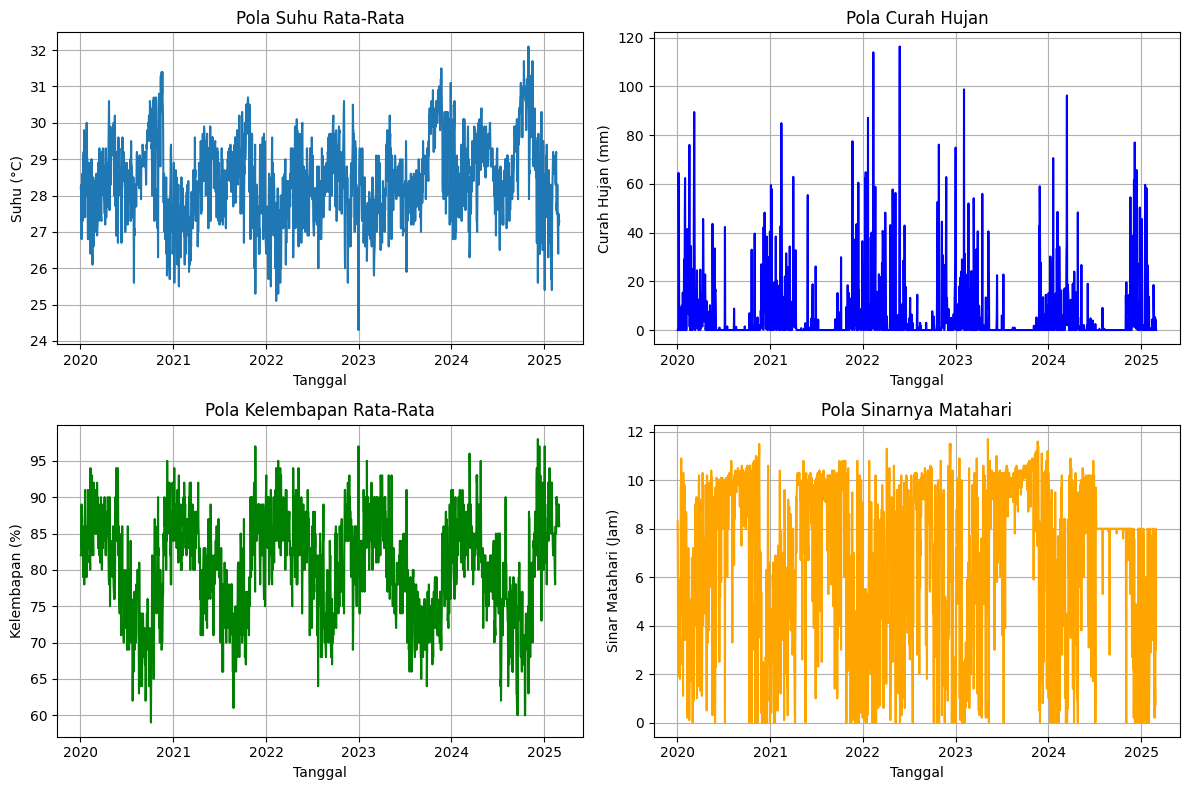

In [18]:
# Visualisasi Pola Cuaca
plt.figure(figsize=(12, 8))
# Suhu Rata-Rata
plt.subplot(2, 2, 1)
plt.plot(df['TANGGAL'], df['TAVG'], label='Suhu Rata-Rata')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.title('Pola Suhu Rata-Rata')
plt.grid(True)
# Curah Hujan
plt.subplot(2, 2, 2)
plt.plot(df['TANGGAL'], df['RR'], label='Curah Hujan', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.title('Pola Curah Hujan')
plt.grid(True)
# Kelembapan Rata-Rata
plt.subplot(2, 2, 3)
plt.plot(df['TANGGAL'], df['RH_AVG'], label='Kelembapan Rata-Rata', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Kelembapan (%)')
plt.title('Pola Kelembapan Rata-Rata')
plt.grid(True)
# Sinarnya Matahari
plt.subplot(2, 2, 4)
plt.plot(df['TANGGAL'], df['SS'], label='Sinarnya Matahari', color='orange')
plt.xlabel('Tanggal')
plt.ylabel('Sinar Matahari (Jam)')
plt.title('Pola Sinarnya Matahari')
plt.grid(True)
# Tampilkan semua grafik
plt.tight_layout()
plt.show()

In [19]:
# Mengubah nama kolom sesuai dengan deskripsi yang lebih mudah dipahami
time_series_data = df.rename(columns={
    'TN': 'Suhu_Min',
    'TX': 'Suhu_Max',
    'RH_AVG': 'Kelembapan_Rata-Rata',
    'RR': 'Curah_Hujan',
    'SS': 'Sinar_Matahari',
    'FF_X': 'Kecepatan_Angin_Max',
    'FF_AVG': 'Kecepatan_Angin_Rata-Rata',
    'TAVG': 'Suhu_Rata-Rata',
    'TX_lag1': 'Suhu_Max_1HariSebelum',
    'TX_rolling3': 'Suhu_Max_Rolling3Hari',
    'TAVG_lag1': 'Suhu_Rata-Rata_1HariSebelum',
    'TAVG_rolling3': 'Suhu_Rata-Rata_Rolling3Hari',
    'RH_AVG_lag1': 'Kelembapan_1HariSebelum',
    'RH_AVG_rolling3': 'Kelembapan_Rolling3Hari',
    'RR_lag1': 'Hujan_1HariSebelum',
    'RR_rolling3': 'Hujan_Rolling3Hari',
    'SS_lag1': 'Matahari_1HariSebelum',
    'SS_rolling3': 'Matahari_Rolling3Hari',
})

In [20]:
print("Data setelah transformasi:")
time_series_data.head()

Data setelah transformasi:


,TANGGAL,Suhu_Min,Suhu_Max,Suhu_Rata-Rata,Kelembapan_Rata-Rata,Curah_Hujan,Sinar_Matahari,Kecepatan_Angin_Max,Kecepatan_Angin_Rata-Rata,Hari,...,Suhu_Max_1HariSebelum,Suhu_Max_Rolling3Hari,Suhu_Rata-Rata_1HariSebelum,Suhu_Rata-Rata_Rolling3Hari,Kelembapan_1HariSebelum,Kelembapan_Rolling3Hari,Hujan_1HariSebelum,Hujan_Rolling3Hari,Matahari_1HariSebelum,Matahari_Rolling3Hari
2,2020-01-03,25.8,32.0,28.2,82,0.0,8.3,12,5,4,...,32.8,31.466667,28.5,27.666667,82.0,84.000000,12.4,11.966667,0.0,3.900000
3,2020-01-04,26.2,31.6,28.3,82,0.4,5.8,8,5,5,...,32.0,32.133333,28.2,28.333333,82.0,82.000000,0.0,4.266667,8.3,4.700000
4,2020-01-05,26.4,32.6,27.7,84,0.1,2.1,14,4,6,...,31.6,32.066667,28.3,28.066667,82.0,82.666667,0.4,0.166667,5.8,5.400000
5,2020-01-06,23.6,32.8,26.8,89,64.5,1.9,9,3,0,...,32.6,32.333333,27.7,27.600000,84.0,85.000000,0.1,21.666667,2.1,3.266667
6,2020-01-07,24.2,32.2,28.2,83,59.3,5.1,11,4,1,...,32.8,32.533333,26.8,27.566667,89.0,85.333333,64.5,41.300000,1.9,3.033333


## 4. Modelling

In [21]:
fitur_dasar = [
    'Kelembapan_Rata-Rata',
    'Curah_Hujan',
    'Sinar_Matahari',
]

In [22]:
fitur_lag = [
    'Suhu_Rata-Rata_1HariSebelum', 'Kelembapan_1HariSebelum',
    'Hujan_1HariSebelum', 'Matahari_1HariSebelum'
]

In [23]:
fitur_rolling = [
    'Suhu_Rata-Rata_Rolling3Hari', 'Kelembapan_Rolling3Hari',
    'Hujan_Rolling3Hari', 'Matahari_Rolling3Hari'
]

In [24]:
fitur_waktu = ['Hari', 'Bulan','Tahun']

In [25]:
# Gabungkan semua fitur
fitur = fitur_dasar + fitur_lag + fitur_rolling + fitur_waktu
target = 'Suhu_Rata-Rata'
# Memisahkan fitur dan target
X = time_series_data[fitur]
y = time_series_data[target]

In [26]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("jumlah data x train: ", X_train.shape)
print("jumlah data y train: ", y_train.shape)
print("jumlah data x test: ", X_test.shape)
print("jumlah data y test: ", y_test.shape)

jumlah data x train:  (1508, 14)
jumlah data y train:  (1508,)
jumlah data x test:  (377, 14)
jumlah data y test:  (377,)


In [27]:
# Simpan hasil split ke file joblib
joblib.dump((X_train, X_test, y_train, y_test), "split_data_suhu.pkl")
print("Data berhasil disimpan ke split_data_suhu.pkl")

Data berhasil disimpan ke split_data_suhu.pkl


### I. Model Random Forest

In [28]:
model_rf = RandomForestRegressor(
    n_estimators=200,    # Meningkatkan jumlah pohon
    min_samples_split=10, # Meningkatkan minimum sampel untuk pembagian
    min_samples_leaf=5,  # Meningkatkan minimum sampel di daun
    random_state=42
)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

#### Evaluasi Model Random Forest

In [29]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
print(f"Random Forest - MAE: {mae_rf:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")
print(f"Random Forest - RMSE: {rmse_rf:.4f}")
print(f"Random Forest - R² Score: {r2_rf:.4f}")
print(f"Random Forest - MAPE: {mape_rf:.4f}%")

Random Forest - MAE: 0.2976
Random Forest - MSE: 0.1436
Random Forest - RMSE: 0.3790
Random Forest - R² Score: 0.8741
Random Forest - MAPE: 1.0480%


#### Visualisasi Hasil Prediksi Random Forest

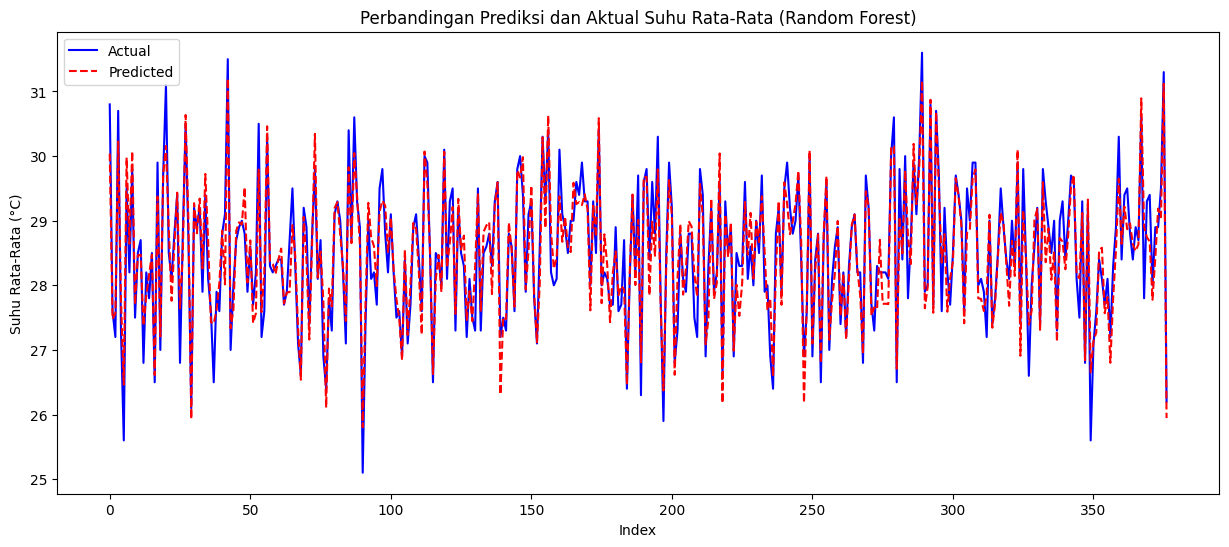

In [30]:
# Visualisasi hasil Random Forest
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_rf, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Random Forest)')
plt.legend()
plt.show()

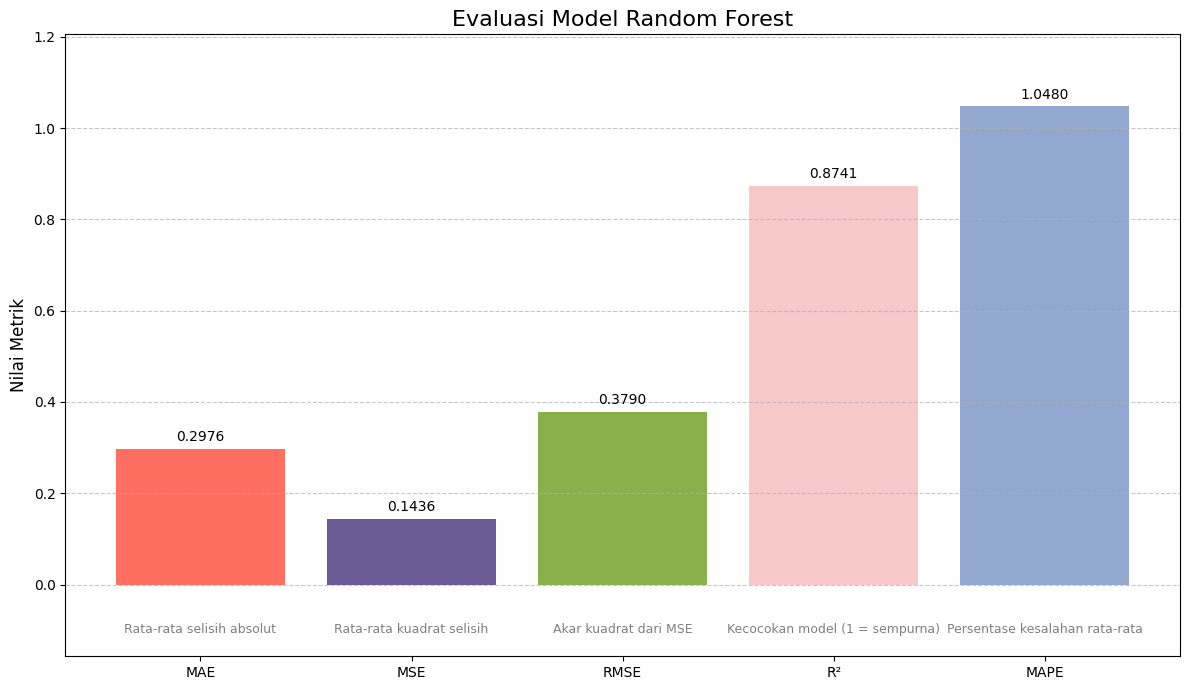

In [31]:
# Data untuk visualisasi
metrics = ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE']
values = [mae_rf, mse_rf, rmse_rf, r2_rf, mape_rf]
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']

# Deskripsi singkat tiap metrik
descriptions = {
    'MAE': 'Rata-rata selisih absolut',
    'MSE': 'Rata-rata kuadrat selisih',
    'RMSE': 'Akar kuadrat dari MSE',
    'R²': 'Kecocokan model (1 = sempurna)',
    'MAPE': 'Persentase kesalahan rata-rata'
}

# Buat diagram batang
plt.figure(figsize=(12, 7))
bars = plt.bar(metrics, values, color=colors)
plt.title('Evaluasi Model Random Forest', fontsize=16)
plt.ylabel('Nilai Metrik', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan nilai di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# Tambahkan penjelasan di bawah sumbu X
for i, metric in enumerate(metrics):
    plt.text(i, -max(values)*0.08, descriptions[metric], ha='center', va='top', fontsize=9, rotation=0, color='gray')

plt.ylim(-max(values)*0.15, max(values)*1.15)
plt.tight_layout()
plt.show()

### II. Model Gradient Boosting

In [32]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

#### Evaluasi Gradient Boosting

In [33]:
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100
print(f"Gradient Boosting - MAE: {mae_gb:.4f}")
print(f"Gradient Boosting - MSE: {mse_gb:.4f}")
print(f"Gradient Boosting - RMSE: {rmse_gb:.4f}")
print(f"Gradient Boosting - R² Score: {r2_gb:.4f}")
print(f"Gradient Boosting - MAPE: {mape_gb:.4f}")

Gradient Boosting - MAE: 0.2878
Gradient Boosting - MSE: 0.1317
Gradient Boosting - RMSE: 0.3629
Gradient Boosting - R² Score: 0.8845
Gradient Boosting - MAPE: 1.0152


#### Visualisasi hasil Gradient Boosting

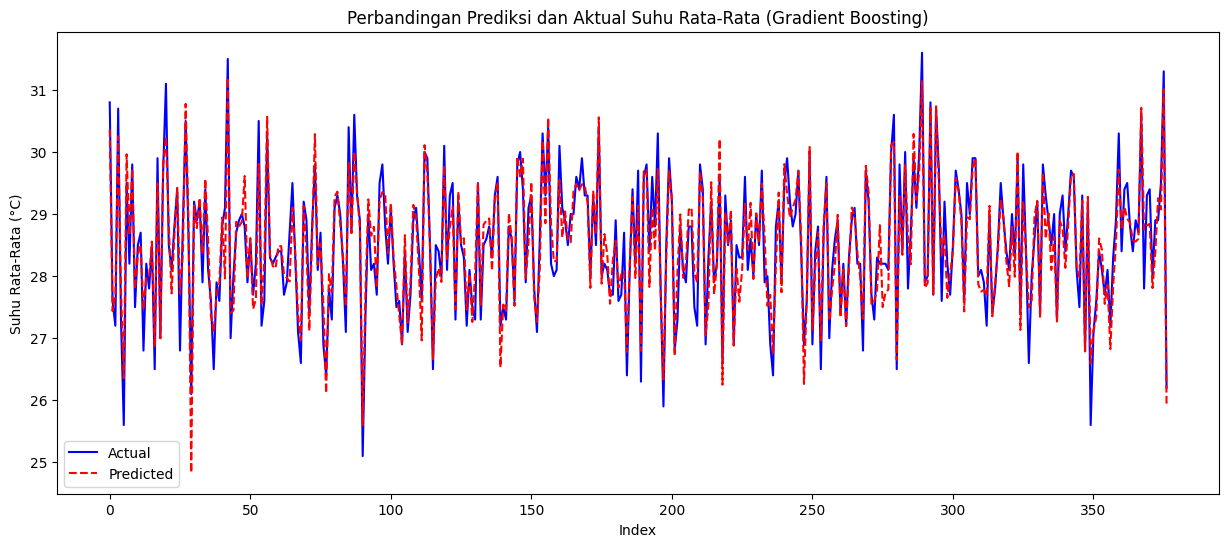

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_gb, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Gradient Boosting)')
plt.legend()
plt.show()

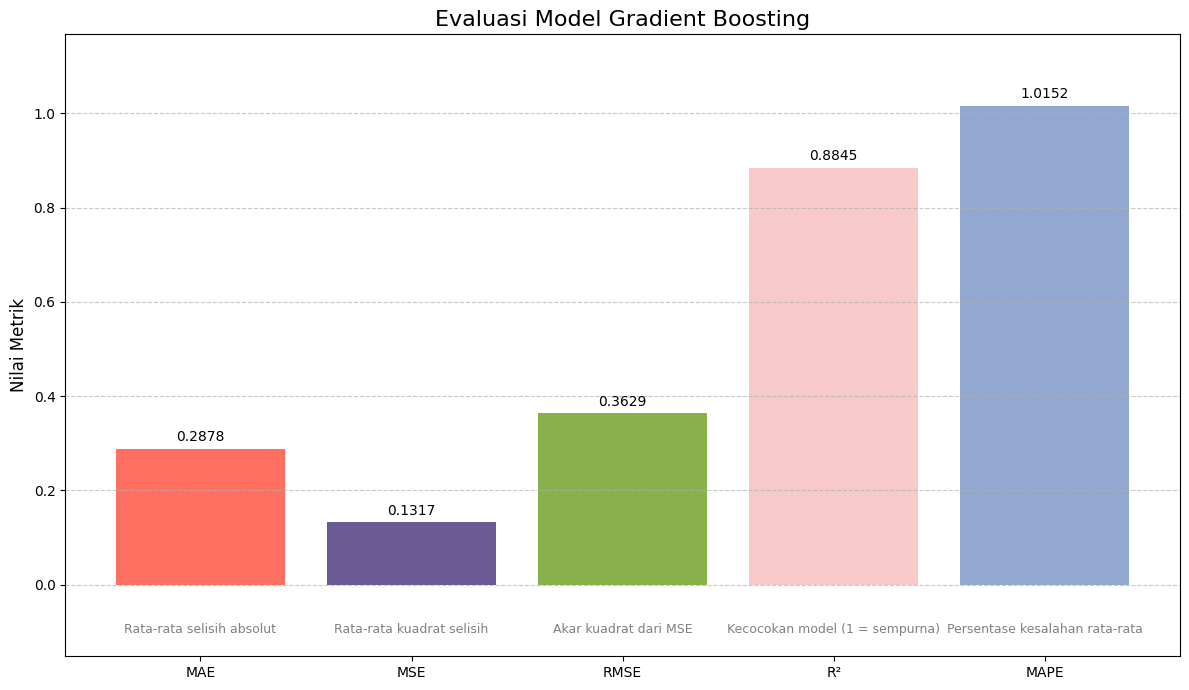

In [35]:
# Data untuk visualisasi
metrics = ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE']
values = [mae_gb, mse_gb, rmse_gb, r2_gb, mape_gb]
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']

# Deskripsi singkat tiap metrik
descriptions = {
    'MAE': 'Rata-rata selisih absolut',
    'MSE': 'Rata-rata kuadrat selisih',
    'RMSE': 'Akar kuadrat dari MSE',
    'R²': 'Kecocokan model (1 = sempurna)',
    'MAPE': 'Persentase kesalahan rata-rata'
}

# Buat diagram batang
plt.figure(figsize=(12, 7))
bars = plt.bar(metrics, values, color=colors)
plt.title('Evaluasi Model Gradient Boosting', fontsize=16)
plt.ylabel('Nilai Metrik', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan nilai di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# Tambahkan penjelasan di bawah sumbu X
for i, metric in enumerate(metrics):
    plt.text(i, -max(values)*0.08, descriptions[metric], ha='center', va='top', fontsize=9, rotation=0, color='gray')

plt.ylim(-max(values)*0.15, max(values)*1.15)
plt.tight_layout()
plt.show()


## III. Model XGBoost Regressor

In [36]:
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

#### Evaluasi model XGBoost

In [37]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100
print(f"XGBoost - MAE: {mae_xgb:.4f}")
print(f"XGBoost - MSE: {mse_xgb:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}")
print(f"XGBoost - R² Score: {r2_xgb:.4f}")
print(f"XGBoost - MAPE: {mape_xgb:.4f}")

XGBoost - MAE: 0.2750
XGBoost - MSE: 0.1187
XGBoost - RMSE: 0.3445
XGBoost - R² Score: 0.8960
XGBoost - MAPE: 0.9697


#### Visualisasi hasil XGBoost

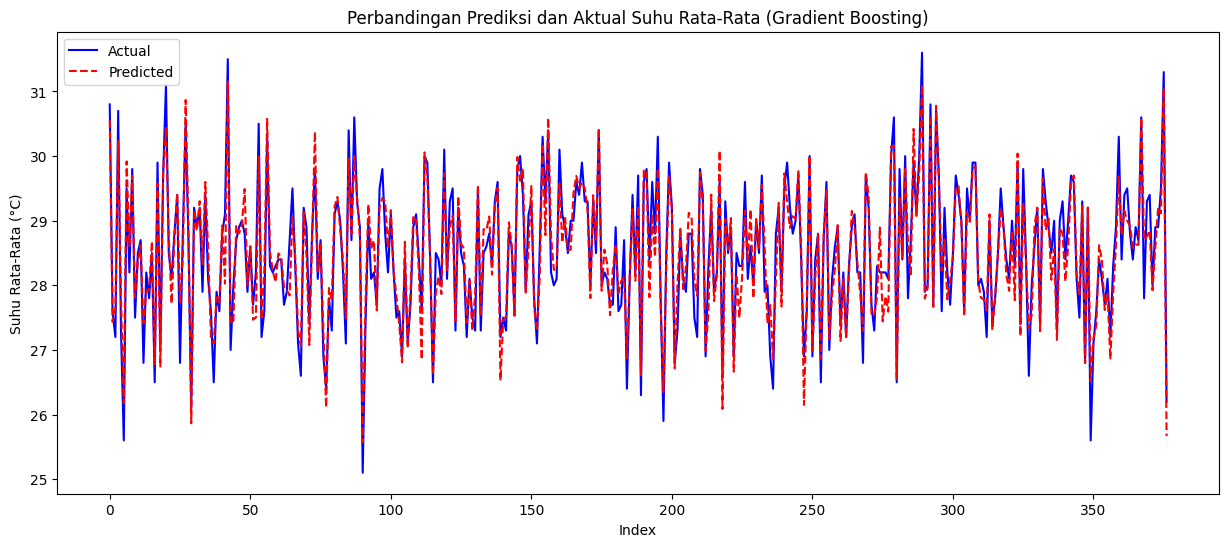

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_xgb, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Suhu Rata-Rata (Gradient Boosting)')
plt.legend()
plt.show()

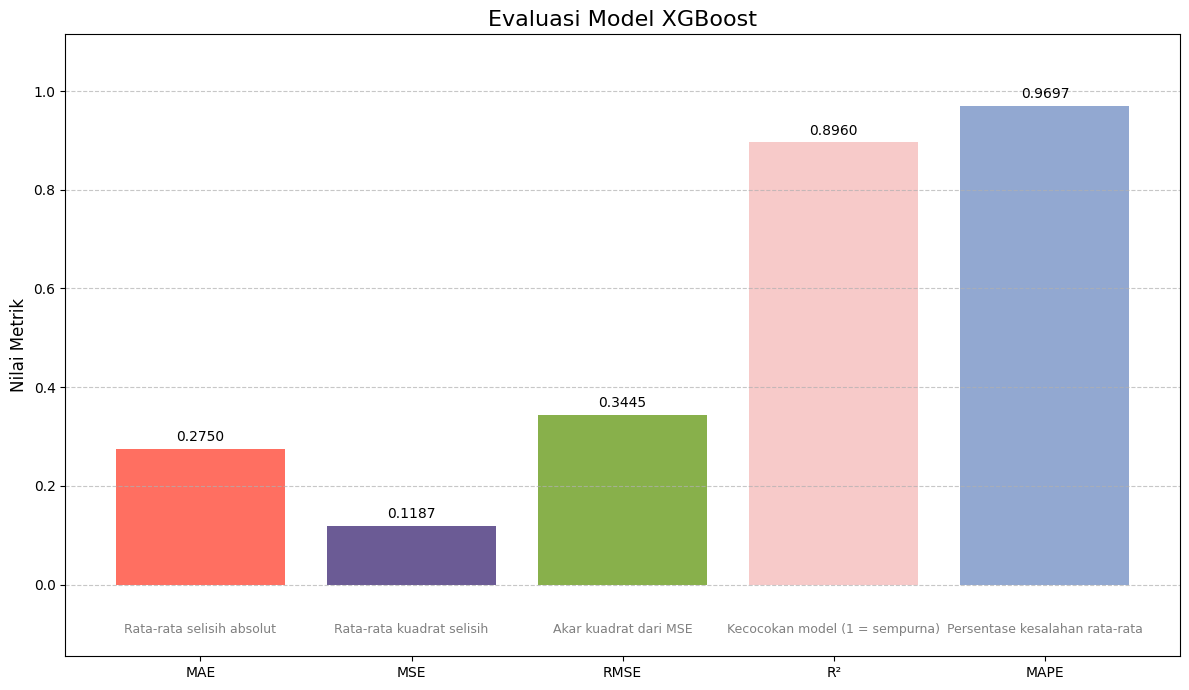

In [39]:
# Data untuk visualisasi
metrics = ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE']
values = [mae_xgb, mse_xgb, rmse_xgb, r2_xgb, mape_xgb]
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1']

# Deskripsi singkat tiap metrik
descriptions = {
    'MAE': 'Rata-rata selisih absolut',
    'MSE': 'Rata-rata kuadrat selisih',
    'RMSE': 'Akar kuadrat dari MSE',
    'R²': 'Kecocokan model (1 = sempurna)',
    'MAPE': 'Persentase kesalahan rata-rata'
}

# Buat diagram batang
plt.figure(figsize=(12, 7))
bars = plt.bar(metrics, values, color=colors)
plt.title('Evaluasi Model XGBoost', fontsize=16)
plt.ylabel('Nilai Metrik', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan nilai di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

# Tambahkan penjelasan di bawah sumbu X
for i, metric in enumerate(metrics):
    plt.text(i, -max(values)*0.08, descriptions[metric], ha='center', va='top', fontsize=9, rotation=0, color='gray')

plt.ylim(-max(values)*0.15, max(values)*1.15)
plt.tight_layout()
plt.show()


## Visual perbandingan dari semua model

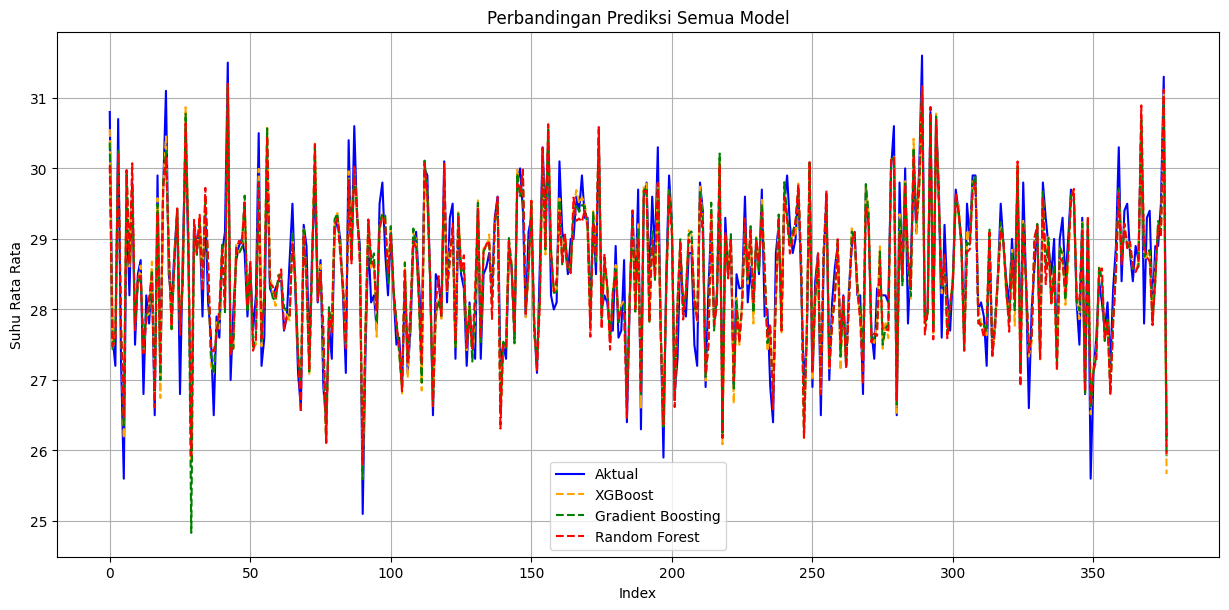

In [40]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.plot(y_test.values, label='Aktual', color='blue')
plt.plot(y_pred_xgb, label='XGBoost', color='orange', linestyle='--')
plt.plot(y_pred_gb, label='Gradient Boosting', color='green',  linestyle='--')
plt.plot(y_pred_rf, label='Random Forest', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata Rata')
plt.title('Perbandingan Prediksi Semua Model')
plt.legend()
plt.grid(True)

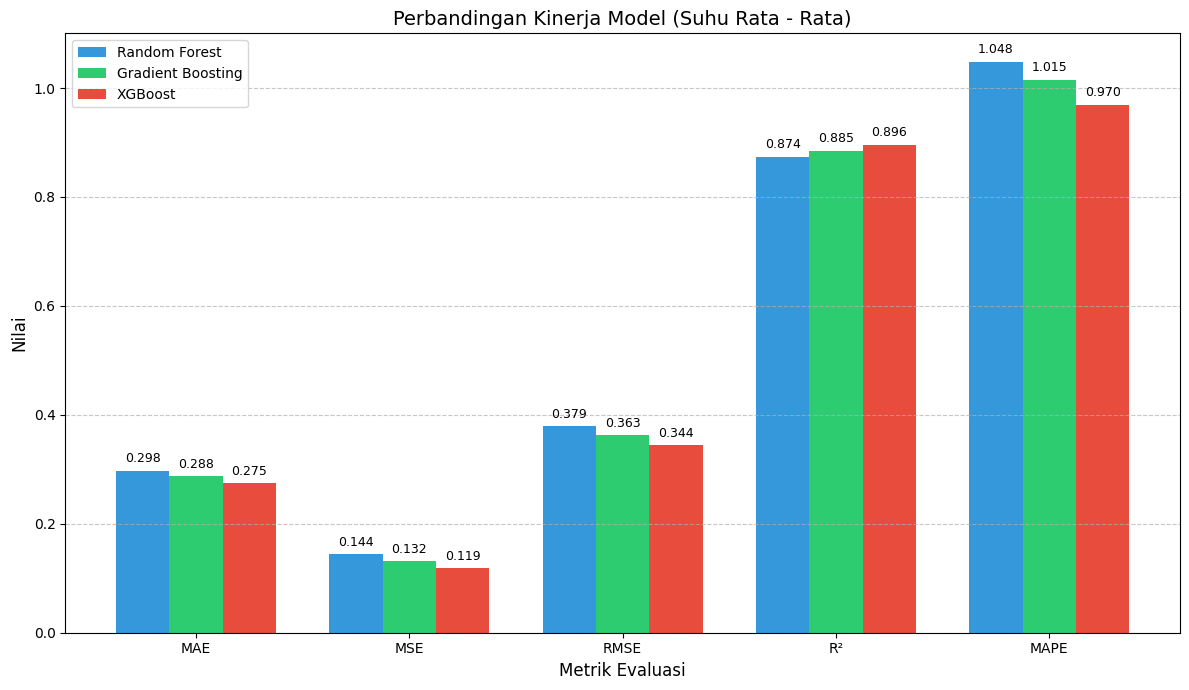

In [41]:
# Kumpulkan semua data
metrics = ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE']
rf_scores = [mae_rf, mse_rf, rmse_rf, r2_rf, mape_rf]
gb_scores = [mae_gb, mse_gb, rmse_gb, r2_gb, mape_gb]
xgb_scores = [mae_xgb, mse_xgb, rmse_xgb, r2_xgb, mape_xgb]

# Pengaturan visual
x = np.arange(len(metrics))  # lokasi label metrik
width = 0.25  # lebar batang

# Buat plot
plt.figure(figsize=(12, 7))
plt.bar(x - width, rf_scores, width=width, label='Random Forest', color='#3498db')
plt.bar(x, gb_scores, width=width, label='Gradient Boosting', color='#2ecc71')
plt.bar(x + width, xgb_scores, width=width, label='XGBoost', color= '#e74c3c')

# Penyesuaian tampilan
plt.xlabel('Metrik Evaluasi', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.title('Perbandingan Kinerja Model (Suhu Rata - Rata)', fontsize=14)
plt.xticks(x, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan nilai di atas setiap batang
def add_labels(scores, positions):
    for score, pos in zip(scores, positions):
        plt.text(pos, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=9)

add_labels(rf_scores, x - width)
add_labels(gb_scores, x)
add_labels(xgb_scores, x + width)

plt.tight_layout()
plt.show()

## 6. Deployment

### Penyimpanan Model dengan Joblib

Setelah model machine learning dilatih dan dievaluasi, langkah berikutnya adalah menyimpan model tersebut agar dapat digunakan kembali tanpa harus melatih ulang dari awal. Salah satu cara yang umum digunakan di Python adalah dengan menggunakan library **Joblib**.

Joblib merupakan library yang efisien untuk menyimpan objek besar seperti model machine learning yang telah dilatih, terutama yang berbasis tree (misalnya: Random Forest, Gradient Boosting, XGBoost). File yang dihasilkan dapat dengan mudah dimuat kembali untuk keperluan prediksi di masa mendatang atau saat digunakan dalam aplikasi deployment (misalnya API, dashboard, dll).


In [42]:
# save model ramdom forest
joblib.dump(model_rf, 'model_suhu_rf.joblib')

['model_suhu_rf.joblib']

In [43]:
# save model gradient boosting
joblib.dump(model_gb, 'model_suhu_gb.joblib')

['model_suhu_gb.joblib']

In [44]:
# save model XGBoost
joblib.dump(y_pred_xgb, 'model_suhu_xgb.joblib')

['model_suhu_xgb.joblib']

In [45]:
model_rf = joblib.load('./model_suhu_rf.joblib')

In [46]:
def prediksi_suhu_masa_depan(data_terakhir, hari_untuk_diprediksi):
    """
    Memprediksi suhu rata-rata untuk beberapa hari ke depan.

    Args:
        data_terakhir: DataFrame dengan data terbaru yang digunakan sebagai dasar prediksi
        hari_untuk_diprediksi: Jumlah hari yang akan diprediksi
    Returns:
        DataFrame berisi tanggal dan prediksi suhu rata-rata
    """
    # Inisialisasi dataframe untuk menyimpan hasil prediksi
    hasil_prediksi = pd.DataFrame(columns=['TANGGAL', 'Suhu_Rata-Rata'])
    
    # Mendapatkan tanggal terakhir dari data
    tanggal_terakhir = data_terakhir['TANGGAL'].max()
    
    # Menyiapkan data untuk prediksi
    data_baru = data_terakhir.copy()
    
    # Fitur-fitur yang digunakan untuk prediksi
    fitur_dasar = [
        'Kelembapan_Rata-Rata',
        'Curah_Hujan',
        'Sinar_Matahari',
    ]
    fitur_lag = [
        'Suhu_Rata-Rata_1HariSebelum', 'Kelembapan_1HariSebelum',
        'Hujan_1HariSebelum', 'Matahari_1HariSebelum'
    ]
    fitur_rolling = [
        'Suhu_Rata-Rata_Rolling3Hari', 'Kelembapan_Rolling3Hari',
        'Hujan_Rolling3Hari', 'Matahari_Rolling3Hari'
    ]
    fitur_waktu = ['Hari', 'Bulan', 'Tahun']
    
    # Semua fitur yang digunakan
    fitur = fitur_dasar + fitur_lag + fitur_rolling + fitur_waktu
    
    # Iterasi untuk memprediksi hari demi hari
    for i in range(hari_untuk_diprediksi):
        # Tanggal untuk prediksi
        tanggal_prediksi = tanggal_terakhir + timedelta(days=i+1)
        
        # Update fitur waktu untuk tanggal prediksi
        data_baru['TANGGAL'] = tanggal_prediksi
        data_baru['Hari'] = tanggal_prediksi.dayofweek
        data_baru['Bulan'] = tanggal_prediksi.month
        data_baru['Tahun'] = tanggal_prediksi.year
        
        # Prediksi suhu untuk hari ini
        X_predict = data_baru[fitur]
        suhu_prediction = model_rf.predict(X_predict)[0]
        
        # Menambahkan hasil prediksi ke DataFrame hasil_prediksi
        hasil_prediksi.loc[i] = [tanggal_prediksi, suhu_prediction]
        
        # Update data untuk prediksi hari berikutnya
        data_baru['Suhu_Rata-Rata_1HariSebelum'] = suhu_prediction
        data_baru['Kelembapan_1HariSebelum'] = data_baru['Kelembapan_Rata-Rata']
        data_baru['Hujan_1HariSebelum'] = data_baru['Curah_Hujan']
        data_baru['Matahari_1HariSebelum'] = data_baru['Sinar_Matahari']
        
        # Update rolling average setelah 3 hari
        if i >= 2:
            prev_3_suhu = hasil_prediksi.loc[i-2:i, 'Suhu_Rata-Rata'].values
            data_baru['Suhu_Rata-Rata_Rolling3Hari'] = np.mean(prev_3_suhu)
    
    return hasil_prediksi

In [47]:
def dapatkan_sampel_data_terakhir():
    """
    Membuat contoh data terakhir untuk demonstrasi.
    """
    sample_data = pd.DataFrame({
        'TANGGAL': [pd.Timestamp('2025-05-19')],
        'Kelembapan_Rata-Rata': [83.0],
        'Curah_Hujan': [0.5],
        'Sinar_Matahari': [7.5],
        'Hari': [4],
        'Bulan': [5],
        'Tahun': [2025],
        'Suhu_Rata-Rata_1HariSebelum': [28.2],
        'Suhu_Rata-Rata_Rolling3Hari': [28.3],
        'Kelembapan_1HariSebelum': [82.5],
        'Kelembapan_Rolling3Hari': [82.0],
        'Hujan_1HariSebelum': [1.0],
        'Hujan_Rolling3Hari': [0.8],
        'Matahari_1HariSebelum': [6.5],
        'Matahari_Rolling3Hari': [7.0]
    })
    
    return sample_data

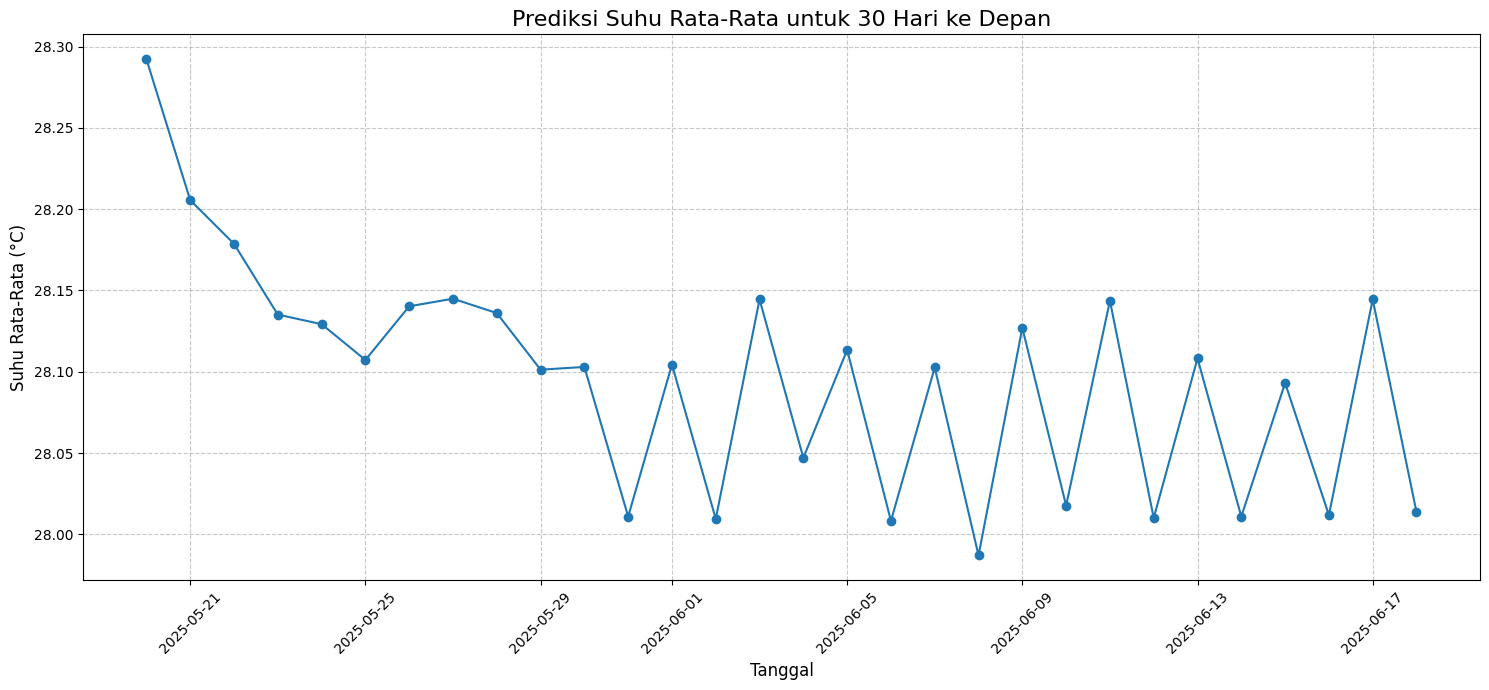

Statistik Prediksi Suhu:
Rata-rata: 28.10°C
Minimum: 27.99°C
Maksimum: 28.29°C


In [48]:
# Gunakan data terakhir untuk prediksi
data_terakhir = dapatkan_sampel_data_terakhir()
prediksi_masa_depan = prediksi_suhu_masa_depan(data_terakhir, hari_untuk_diprediksi=30)

# Visualisasikan hasil prediksi
plt.figure(figsize=(15, 7))
plt.plot(prediksi_masa_depan['TANGGAL'], prediksi_masa_depan['Suhu_Rata-Rata'], marker='o', linestyle='-')
plt.title('Prediksi Suhu Rata-Rata untuk 30 Hari ke Depan', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Suhu Rata-Rata (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Statistik Prediksi Suhu:")
print(f"Rata-rata: {prediksi_masa_depan['Suhu_Rata-Rata'].mean():.2f}°C")
print(f"Minimum: {prediksi_masa_depan['Suhu_Rata-Rata'].min():.2f}°C")
print(f"Maksimum: {prediksi_masa_depan['Suhu_Rata-Rata'].max():.2f}°C")

# Simpan hasil prediksi ke file CSV
# prediksi_masa_depan.to_csv('prediksi_suhu_30hari.csv', index=False)
# print("Hasil prediksi telah disimpan ke 'prediksi_suhu_30hari.csv'")